In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import pylab
import tensorflow as tf
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller

/home/michaeljgrogan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/michaeljgrogan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/michaeljgrogan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/michaeljgrogan/.local/lib/python3.6/site-packages/tensorflow/

'/media/veracrypt9/a_documents/group b/computing/languages/python/electricity-consumption-neural-master'

In [2]:
# Form dataset matrix
def create_dataset(dataset, previous=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-previous-1):
		a = dataset[i:(i+previous), 0]
		dataX.append(a)
		dataY.append(dataset[i + previous, 0])
	return np.array(dataX), np.array(dataY)

In [3]:
# fix random seed for reproducibility
np.random.seed(7)

# load dataset
df = read_csv('dccelectricitycivicsblocks34p20130221-1840.csv', engine='python', skipfooter=3)
df

,Civic Offices Blocks 3 and 4 KWh,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97
0,Date,Values,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
1,29/03/2011,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.80000305,31.20000076,31.65000153,30.60000038,32.85000229,31.05000305,32.10000229,31.35000229,31.65000153,30.15000153
2,30/03/2011,96,32.10000229,32.40000153,33.60000229,33,29.70000076,30.90000153,31.50000191,33,...,35.70000076,33.60000229,34.20000076,34.80000305,34.65000153,33.75,33.15000153,32.70000076,31.50000191,33.60000229
3,31/03/2011,96,32.10000229,33.60000229,35.10000229,33.45000076,31.20000076,31.35000038,34.20000076,33.75,...,33,33,35.25,34.35000229,32.40000153,31.20000076,32.84999847,33.45000076,32.10000229,32.10000229
4,01/04/2011,96,32.70000076,34.5,30.30000305,33,33,31.5,30.30000305,32.84999847,...,32.25,33.45000076,33,30.45000076,33.15000153,30.60000229,30.15000153,32.55000305,33,30.15000153
5,02/04/2011,96,31.80000114,32.40000153,30.45000076,33.90000153,33.30000305,30.75000191,30.75,29.85000038,...,34.5,31.80000114,32.10000229,31.80000114,35.25,34.65000153,30.45000076,31.5,33.45000076,32.55000305
6,03/04/2011,96,32.85000229,30.30000114,32.10000229,30,34.05000305,30.75000191,32.10000229,28.80000114,...,34.95000076,31.80000114,35.10000229,33.90000153,31.35000038,35.10000229,35.10000229,33.90000153,31.35000038,35.10000229
7,04/04/2011,96,32.25000381,35.40000153,37.34999847,34.35000229,34.95000076,36.45000076,36.15000153,33.15000153,...,32.55000305,31.65000153,32.10000229,31.95000076,29.39999962,30.75,31.95000076,31.35000229,32.70000076,30.75
8,05/04/2011,96,30.90000153,32.85000229,32.10000229,35.55000305,32.55000305,33,31.80000114,31.5,...,33.30000305,32.25,32.70000076,31.95000267,33.30000305,32.85000229,33.45000076,28.35000229,31.80000305,34.65000153
9,06/04/2011,96,32.55000305,30.30000114,33,29.70000076,33.60000229,32.70000076,28.95000076,28.20000076,...,33.75,30,34.80000305,31.50000191,30.60000229,33.45000076,33.00000381,34.04999924,30.90000153,29.10000038


In [4]:
df2=df.rename(columns=df.iloc[0])
df3=df2.drop(df.index[0])
df3
df3.drop(df3.index[0])
df4=df3.drop('Date', axis=1)
df5=df4.drop('Values', axis=1)
df5
df6=df5.dropna()
df7=df6.values
df7
dataset=np.sum(df7, axis=1, dtype=float)
dataset

array([4981.5001927 , 5166.60016445, 3046.35014537, 3101.10013769,
       4908.60016439, 4858.50017742, 4905.00019836, 4999.95019526,
       3075.90013122, 3023.5501442 , 5004.6001587 , 5199.30019957,
       5226.75017163, 5162.55022428, 4991.55017468, 2950.20010378,
       4883.85017776, 5055.15017129, 5084.10021592, 4914.00019451,
       3581.55014991, 2981.55008892, 2967.00011064, 3515.70014566,
       4721.10016438, 4931.85019494, 5020.05018234, 4799.40017322,
       3043.20012856, 2929.05012318, 3423.45014192, 4949.55017475,
       5155.05015188, 5238.75021174, 5129.10016059, 3088.95013995,
       3017.40010454, 5041.95018196, 5170.80017096, 5250.90023994,
       5239.35021975, 5163.60019308, 3169.65013694, 3034.65012932,
       5056.05021094, 5052.6001988 , 5048.2501869 , 4971.75019264,
       3013.20013239, 2919.45011703, 4830.0002022 , 5007.90018087,
       5028.00018885, 5088.60017207, 5092.35015869, 3069.90011787,
       2909.85011099, 4923.60022544, 5136.75021744, 5233.65021

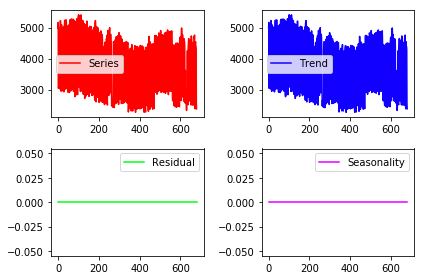

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(dataset, model='additive', freq=1)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.subplot(221)
plt.plot(dataset,color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual,color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal,color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

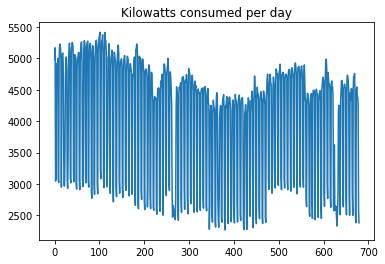

In [6]:
plt.plot(dataset)
plt.title("Kilowatts consumed per day")
plt.show()

std1=np.std(dataset)
mean1=np.mean(dataset)
cv1=std1/mean1 #Coefficient of Variation

from numpy import log
dataset = log(dataset)

std2=np.std(dataset)
mean2=np.mean(dataset)
cv2=std2/mean2 #Coefficient of Variation

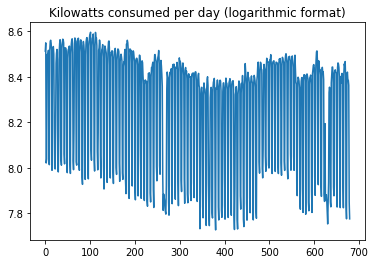

In [7]:
plt.plot(dataset)
plt.title("Kilowatts consumed per day (logarithmic format)")
plt.show()

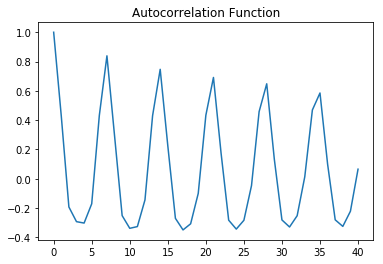

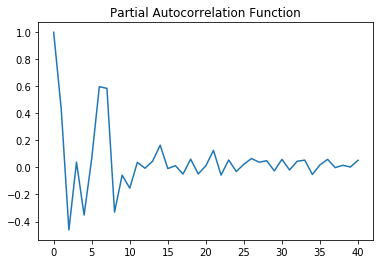

In [8]:
acf=statsmodels.tsa.stattools.acf(dataset)
plt.plot(acf)
plt.title("Autocorrelation Function")
plt.show()
pacf=statsmodels.tsa.stattools.pacf(dataset)
plt.title("Partial Autocorrelation Function")
plt.plot(pacf)
plt.show()

In [9]:
# Dickey-Fuller Test
result = adfuller(dataset)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.251146
p-value: 0.017209
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [10]:
meankwh=np.mean(dataset)

dataset=dataset.reshape(-1,1)

# normalize dataset with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.90428224],
       [0.94625893],
       [0.33845307],
       [0.35894764],
       [0.88732039],
       [0.8755168 ],
       [0.88647626],
       [0.90853569],
       [0.34955984],
       [0.32980949],
       [0.90960522],
       [0.953518  ],
       [0.95957645],
       [0.94535669],
       [0.90660111],
       [0.3015533 ],
       [0.88150441],
       [0.92116837],
       [0.92773863],
       [0.88858544],
       [0.52467256],
       [0.31371508],
       [0.30808661],
       [0.50332165],
       [0.84250969],
       [0.89275724],
       [0.91315171],
       [0.86143531],
       [0.33726274],
       [0.29327525],
       [0.4727285 ],
       [0.8968791 ],
       [0.94368396],
       [0.96221497],
       [0.93787754],
       [0.35443095],
       [0.32746682],
       [0.91816011],
       [0.94719385],
       [0.96488033],
       [0.96234674],
       [0.94559067],
       [0.38410376],
       [0.33402565],
       [0.9213732 ],
       [0.92058784],
       [0.91959685],
       [0.902

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Training and Test data partition
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t-50 and Y=t (MODIFY TIME HERE)
previous = 50
X_train, Y_train = create_dataset(train, previous)
X_test, Y_test = create_dataset(test, previous)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, previous)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=150, batch_size=1, verbose=2)

Train on 493 samples
Epoch 1/150
493/493 - 4s - loss: 0.0796
Epoch 2/150
493/493 - 2s - loss: 0.0294
Epoch 3/150
493/493 - 2s - loss: 0.0251
Epoch 4/150
493/493 - 2s - loss: 0.0225
Epoch 5/150
493/493 - 2s - loss: 0.0208
Epoch 6/150
493/493 - 2s - loss: 0.0196
Epoch 7/150
493/493 - 3s - loss: 0.0187
Epoch 8/150
493/493 - 2s - loss: 0.0171
Epoch 9/150
493/493 - 2s - loss: 0.0166
Epoch 10/150
493/493 - 2s - loss: 0.0160
Epoch 11/150
493/493 - 2s - loss: 0.0151
Epoch 12/150
493/493 - 2s - loss: 0.0149
Epoch 13/150
493/493 - 2s - loss: 0.0144
Epoch 14/150
493/493 - 2s - loss: 0.0139
Epoch 15/150
493/493 - 2s - loss: 0.0135
Epoch 16/150
493/493 - 2s - loss: 0.0138
Epoch 17/150
493/493 - 2s - loss: 0.0133
Epoch 18/150
493/493 - 2s - loss: 0.0133
Epoch 19/150
493/493 - 2s - loss: 0.0129
Epoch 20/150
493/493 - 2s - loss: 0.0129
Epoch 21/150
493/493 - 2s - loss: 0.0119
Epoch 22/150
493/493 - 2s - loss: 0.0120
Epoch 23/150
493/493 - 2s - loss: 0.0120
Epoch 24/150
493/493 - 2s - loss: 0.0117
Epoc

In [14]:
# Generate predictions
trainpred = model.predict(X_train)
testpred = model.predict(X_test)

Train Score: 0.07 RMSE
Test Score: 0.14 RMSE


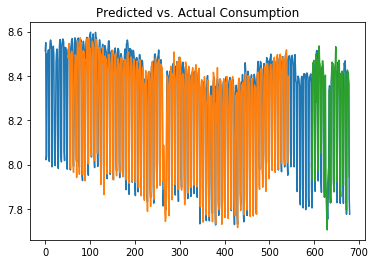

In [15]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
testpred = scaler.inverse_transform(testpred)
Y_test = scaler.inverse_transform([Y_test])
predictions = testpred

# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], testpred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Train predictions
trainpredPlot = np.empty_like(dataset)
trainpredPlot[:, :] = np.nan
trainpredPlot[previous:len(trainpred)+previous, :] = trainpred

# Test predictions
testpredPlot = np.empty_like(dataset)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred)+(previous*2)+1:len(dataset)-1, :] = testpred

# Plot all predictions
inversetransform, =plt.plot(scaler.inverse_transform(dataset))
trainpred, =plt.plot(trainpredPlot)
testpred, =plt.plot(testpredPlot)
plt.title("Predicted vs. Actual Consumption")
plt.show()

In [16]:
Y_test=np.exp(Y_test)
predictions=predictions.reshape(1,-1)
predictions=np.exp(predictions)

percentage_error=((predictions-Y_test)/Y_test)
percentage_error=abs(percentage_error)
mean=np.mean(percentage_error)
mean

0.08579582604797127

In [17]:
percentage_error=pd.DataFrame(percentage_error)
below10=percentage_error[percentage_error < 0.10].count()
all=percentage_error.count()
np.sum(below10)

62

In [18]:
np.sum(all)

85